# Demo Resource Synchronization
Synchronization of resources means that before objects can be moved from one location to another, the processor as well as the origin and the destination resource must be available. If a resource is not available the process will wait untill the resource available.

Currently this waiting time is not recorded in the logs. The waiting time can be derived from the activity log by identifying time differences between the completion of an activity and the start of the subsequent activity.

This is an incomplete feature since preserve reservations can not be released automatically. Recommendation is to have a request_resource and a release_resource activity.

The current mechanism is based on two attributes of activities
- **keep_resources** a list of resources, which should not be released at the end of an activity
- **reserved_resources** is a dictionary, should be initialized for all activities of a process with the same variable. This will enable the transfer of reserved resources from one activity to another one.

In [1]:
import datetime, time
import simpy

import shapely.geometry

import pandas as pd
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)
registry = {}
keep_resources = {}

## Definition of Site

In [2]:
# The generic site class
Site = type(
    "Site",
    (
        core.Identifiable,  # Give it a name
        core.Log,  # Allow logging of all discrete events
        core.Locatable,  # Add coordinates to extract distance information and visualize
        core.HasContainer,  # Add information on the material available at the site
        core.HasResource,
    ),  # Add information on serving equipment
    {},
)  # The dictionary is empty because the site type is generic

# Information on the extraction site - the "from site" - the "win locatie"
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)  # lon, lat

data_from_site = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "Winlocatie",  # The name of the site
    "ID": "6dbbbdf4-4589-11e9-a501-b469212bff5d",  # For logging purposes
    "geometry": location_from_site,  # The coordinates of the project site
    "capacity": 10,  # The capacity of the site
    "level": 8,
}  # The actual volume of the site

# The two objects used for the simulation
from_site = Site(**data_from_site)

## Definition of Vessels

In [3]:
# The generic class for an object that can move and transport (a TSHD for example)
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,  # Give it a name
        core.Log,  # Allow logging of all discrete events
        core.ContainerDependentMovable,  # A moving container, so capacity and location
        core.Processor,  # Allow for loading and unloading
        core.HasResource,  # Add information on serving equipment
        core.LoadingFunction,  # Add a loading function
        core.UnloadingFunction,  # Add an unloading function
    ),
    {},
)

# For more realistic simulation you might want to have speed dependent on the volume carried by the vessel
def compute_v_provider(v_empty, v_full):
    return lambda x: 10


# TSHD variables
data_hopper1 = {
    "env": my_env,  # The simpy environment
    "name": "Hopper 01",  # Name
    "ID": "6dbbbdf6-4589-11e9-95a2-b469212bff5b",  # For logging purposes
    "geometry": location_from_site,  # It starts at the "from site"
    "loading_rate": 1,  # Loading rate
    "unloading_rate": 1,  # Unloading rate
    "capacity": 4,  # Capacity of the hopper - "Beunvolume"
    "compute_v": compute_v_provider(5, 4.5),  # Variable speed
}

hopper1 = TransportProcessingResource(**data_hopper1)

data_hopper2 = {
    "env": my_env,  # The simpy environment
    "name": "Hopper 02",  # Name
    "ID": "5dbbbdf6-4589-11e9-95a2-b469212bff5b",  # For logging purposes
    "geometry": location_from_site,  # It starts at the "from site"
    "loading_rate": 1,  # Loading rate
    "unloading_rate": 1,  # Unloading rate
    "capacity": 4,  # Capacity of the hopper - "Beunvolume"
    "compute_v": compute_v_provider(5, 4.5),  # Variable speed
}
hopper2 = TransportProcessingResource(**data_hopper2)

## Definition of the process for hopper1
Then **requested_resources1** variable is used to initialize all activities below. This enables the transfer of reserved resources to the next activity.
The **keep_resources** parameter tells that after hopper1 has received an object from *from_site* it should not release the *from_site* resource.

In [4]:
requested_resources1 = {}
shift_amount_activity_loading_data1 = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "Transfer1",  # We are moving soil
    "ID": "6dbbbdf7-4589-11e9-bf3b-b469212bff52",  # For logging purposes
    "registry": registry,
    "processor": hopper1,
    "origin": from_site,
    "destination": hopper1,
    "amount": 1,
    "duration": 20,
    "postpone_start": True,
    #"keep_resources":[from_site],
    "requested_resources": requested_resources1,
}
activity1 = model.ShiftAmountActivity(**shift_amount_activity_loading_data1)

sequential_activity_data1 = {
    "env": my_env,
    "name": "Sequential process1",
    "ID": "6dbbbdf7-4589-11e9-bf3b-b469212bff60",  # For logging purposes
    "registry": registry,
    "sub_processes": [activity1],
    "postpone_start": True,
    "requested_resources": requested_resources1,
}
seq_activity1 = model.SequentialActivity(**sequential_activity_data1)

while_data1 = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "while1",  # We are moving soil
    "ID": "6dbbbdf7-4589-11e9-bf3b-b469212bff5g",  # For logging purposes
    "registry": registry,
    "sub_processes": [seq_activity1],
    "condition_event": [{"or":[{"type":"container", "concept": hopper1, "state":"full"},
               {"type":"container", "concept": from_site, "state":"empty"}]
         }],
    "postpone_start": False,
    "requested_resources": requested_resources1,
}
while_activity1 = model.WhileActivity(**while_data1)

## Definition of process for hopper2
This is a normal process without special parameters.

In [5]:
shift_amount_activity_loading_data2 = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "Transfer2",  # We are moving soil
    "ID": "5dbbbdf7-4589-11e9-bf3b-b469212bff52",  # For logging purposes
    "registry": registry,
    "processor": hopper2,
    "origin": from_site,
    "destination": hopper2,
    "amount": 1,
    "duration": 20,
    "postpone_start": True,
}
activity2 = model.ShiftAmountActivity(**shift_amount_activity_loading_data2)

sequential_activity_data2 = {
    "env": my_env,
    "name": "Sequential process2",
    "ID": "5dbbbdf7-4589-11e9-bf3b-b469212bff60",  # For logging purposes
    "registry": registry,
    "sub_processes": [activity2],
    "postpone_start": True,
}
seq_activity2 = model.SequentialActivity(**sequential_activity_data2)

while_data2 = {
    "env": my_env,  # The simpy environment defined in the first cel
    "name": "while2",  # We are moving soil
    "ID": "5dbbbdf7-4589-11e9-bf3b-b469212bff5g",  # For logging purposes
    "registry": registry,
    "sub_processes": [seq_activity2],
    "condition_event": [{"or":[{"type":"container", "concept": hopper2, "state":"full"},
               {"type":"container", "concept": from_site, "state":"empty"}]
         }],
    "postpone_start": False,
}
while_activity2 = model.WhileActivity(**while_data2)


In [6]:
my_env.run()

In [7]:
plot.get_log_dataframe(from_site, [while_activity2, seq_activity2, activity2, while_activity1, seq_activity1, activity1])

,Activity,Timestamp,ActivityState,container level,geometry
0,Transfer1,1970-01-01 00:00:00,START,8.0,POINT (4.18055556 52.18664444)
1,Transfer1,1970-01-01 00:00:20,STOP,7.0,POINT (4.18055556 52.18664444)
2,Transfer2,1970-01-01 00:00:20,START,7.0,POINT (4.18055556 52.18664444)
3,Transfer2,1970-01-01 00:00:40,STOP,6.0,POINT (4.18055556 52.18664444)
4,Transfer1,1970-01-01 00:00:40,START,6.0,POINT (4.18055556 52.18664444)
5,Transfer1,1970-01-01 00:01:00,STOP,5.0,POINT (4.18055556 52.18664444)
6,Transfer2,1970-01-01 00:01:00,START,5.0,POINT (4.18055556 52.18664444)
7,Transfer2,1970-01-01 00:01:20,STOP,4.0,POINT (4.18055556 52.18664444)
8,Transfer1,1970-01-01 00:01:20,START,4.0,POINT (4.18055556 52.18664444)
9,Transfer1,1970-01-01 00:01:40,STOP,3.0,POINT (4.18055556 52.18664444)


Interesting in this scenario is that the process of hopper2 is not executed at all because hopper1 takes requests the resource *from_site* and never releases it again, thus hopper2 process can not start.

By commenting out the **keep_resource** parameter in shift amount activity of hopper1, will result in hopper1 and hopper2 getting access to the resource *from_site* one after each other.

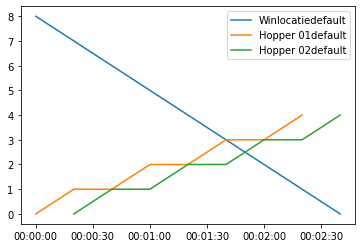

In [8]:
fig = plot.get_step_chart([from_site, hopper1, hopper2])